# Team composed by:
- Agostara Nicolò
- Fratti Giorgio
- Fusillo Antonio
- Protti Edoardo

## THEORETICAL FRAMEWORK

The dataset contains ratings of items by users

For each couple $(u, i)$ of a user and a item, we consider
the discrete random variable $R(u, i)$ = "item i is relevant for user u"
$R(u, i) \in \{0, 1\}$ for every $u, i$
In this scenario "relevant" doesn't assume the usual meaning
it refers to a "relevance" by a reccomender system point of view

If a user u rated an item i, then he interacted with it,
in this case we assume to have a realization $r(u, i) = 1 \text{ of } R(u, i)$

Since we only have items ratings in our dataset, we don't have any "negative"
realization of $R(u, i)$, i.e. any realization $r(u, i) = 0$

For this reason we make a sampling from the unrealized variables, i.e
the variables $R(u, i)$ such in our dataset there is not a rating of item i by user u

Given our final dataset, consisting in realizations of a subset of the variables $\{R(u, i): \text{u user, i item}\}$
we want to maximize the likelihood function of the model, i.e.
$$L = \prod p(R(u, i) = r(u, i)) = (\prod_{i+} p(R(u, i) = 1)) \times (\prod_{i-} p(R(u, i) = 0)$$ 
splitting the products between positive and negative realizations

Our model returns the value $f(u, i) = p(R(u, i) = 1)$ i.e. the "probability of relevance of item i for user u"
Passing to maximize the log likelihood function we want to maximize:
$$
\begin{aligned}
\log L &= \sum_{u,i} \log p(R(u, i) = 1) + \sum_{u,i} \log p(R(u,i) = 0)\\
&= \sum_{u,i} \log p(R(u, i) = 1) + \sum_{u,i} \log (1 - p(R(u, i) = 1))\\
&= \sum_{u,i} \log f(u, i) + \sum_{u,i} \log (1 - f(u, i))\\
&= ... =\mathrm{BCE}(f)
\end{aligned}
$$

### IMPORT LIBRARIES

In [1]:
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time

from neumf import NeuMF

# Preliminary Definitions

## PATH definition

In [2]:
PATH = "./ml-100k/u.data" 
MODEL_PATH = "./models/" 

## Parameters definition

In [3]:
args = {
    "seed": 42,
    "lr": 0.001,
    "dropout": 0.2,
    "batch_size": 256,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 32,
    "layers": (32, 16, 8),
    "out": True,
    "num_ng": 4,
    "num_ng_test": 100
}

In [4]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Evaluation Metrics

In [5]:
def hit(ng_item, pred_items):
    return 1 if ng_item in pred_items else 0


def ndcg(ng_item, pred_items):
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index + 2))
    return 0


def metrics(model, test_loader, top_k, device):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        ng_item = item[0].item()  # leave one-out evaluation has only one item per user
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)


# Data preprocessing

In [6]:
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)


In [7]:

class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, ratings):
		self.ratings = ratings
		self.num_ng = args["num_ng"]
		self.num_ng_test = args["num_ng_test"]
		self.batch_size = args["batch_size"]

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)

	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

In [8]:
# load data
ml_100k = pd.read_csv(
	PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

/tmp/ipykernel_7212/394196750.py:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_7212/394196750.py:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))


# Models Definition

## Training function for GMF, MLP and NeuMF models

### Train Model function
We define the function that will train the models.
The function takes in input the model, the train data loader and the test dataloader.
It does:

Set the loss function to BCE

Set the optimizer to Adam

For each epoch:
- Train over the batches
- Evaluate the metrics (HR and NDCG)
- Save the best model (based on HR)

In [9]:
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader):
    model = model.to(device)

    # Loss and optimizer
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])

    best_hr = 0
    
    # Train cycle
    for epoch in range(args["epochs"]):
        start_time = time.time()
        
        # Train step
        model.train()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            # Zero grad
            optimizer.zero_grad()
            
            # Prediction
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Eval metrics
        model.eval()
        HR, NDCG = metrics(model, test_loader, args["top_k"], device)

        # Print metrics and time elapsed
        elapsed_time = time.time() - start_time
        print(
            "Epoch {:03d}".format(epoch)
            + " time to train: "
            + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
        )
        print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

        # If best model, save it
        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model, "{}{}{}.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors)
                )


## General Matrix Factorization (GMF)

In [10]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


### Training and save of GMF model

In [11]:
#gmf_model = GMF(num_users, num_items)
#train_model(gmf_model, train_loader, test_loader)

## Multi Layer Perceptron (MLP)

In [12]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=num_users, embedding_dim=args["num_factors"]
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=num_items, embedding_dim=args["num_factors"]
        )

        layer_sizes = args["layers"]
        layers = []
        layers.append(nn.Linear(args["num_factors"] * 2, layer_sizes[0]))
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        self.mlp_fc = nn.Sequential(*layers)
        self.mlp_fc.add_module("affine", nn.Linear(layer_sizes[-1], 1))
        self.mlp_fc.add_module("logit", nn.Sigmoid())

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        rating = self.mlp_fc(vector)
        return rating.squeeze()


### Training and Save of MLP model

In [13]:
#mlp_model = MLP(num_users, num_items)
#train_model(mlp_model, train_loader, test_loader)

# Task 1 - Neural Matrix Factorization

### Neural Matrix Factorization class definition
The class is defined in the neumf.py file in order to avoid a pickle error in the Hyperparameter tuning section (at the end of the file). 

The following class is reported to show the structure and is renamed to avoid name conflicts.

Idea: combine structures of GMF and MLP models for obtaining a more accurate relevance score. We allow GMF and MLP to have different num_factors.

From the GMF we removed the Sigmoid layer and put the out dimension of the linear layer to num_factors_gmf.

Also from the MLP we removed its final Sigmoid layer and the last linear layer and its structure has been modified to obtain a tower, halving its input dimension( = concatenation of user and item embeddings) 3 times.
For instance: if num_factor_MLP = 64, then the concatenation of the embeddings has size 128 and it is halved with 3 layers: 128->64, 64->32, 32->16.

Then, we concatenate the two final layers of the "pruned" GMF and MLP and pass it to a MLP tower-like structure with 2 halving layers and finally a linear layer followed by a Sigmoid.

In [14]:
class NeuMF_class(nn.Module):
    def __init__(self, num_factors_gmf, num_factors_mlp, num_users, num_items, dropout):

        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.dropout = dropout
        self.num_factors_gmf = num_factors_gmf 
        self.num_factors_mlp = num_factors_mlp 
        self.num_factors = max(num_factors_mlp, num_factors_gmf) #just for saving model name purpose

        # GMF component
        self.gmf_user_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors_gmf),
            nn.Dropout(p=self.dropout[1]),
        )
        self.gmf_item_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors_gmf),
            nn.Dropout(p=self.dropout[1]),
        )
        self.gmf_affine = nn.Linear(
            in_features=self.num_factors_gmf, out_features=self.num_factors_gmf, bias=True
        )

        # MLP component
        self.mlp_user_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors_mlp),
            nn.Dropout(p=self.dropout[2]),
        )
        self.mlp_item_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors_mlp),
            nn.Dropout(p=self.dropout[2]),
        )

        self.mlp_fc = nn.Sequential(
            #We have considered as possible num_factors [8, 16, 32, 64] so this structure works
            nn.Linear(2 * self.num_factors_mlp, self.num_factors_mlp),
            nn.Dropout(p = dropout[3]),
            nn.ReLU(),

            nn.Linear(self.num_factors_mlp, int(self.num_factors_mlp / 2)),
            nn.Dropout(p = dropout[3] / 2),
            nn.ReLU(),

            nn.Linear(int(self.num_factors_mlp / 2), int(self.num_factors_mlp / 4)),  
            nn.Dropout(p = dropout[3] / 4),
            nn.ReLU()
        )

        # Combine models
        input_dim = self.num_factors_gmf + int(self.num_factors_mlp / 4)
        self.mixing_layers = nn.Sequential(
            nn.Linear(input_dim, int(input_dim / 2)),
            nn.Dropout(p=dropout[0]),
            nn.ReLU(),

            nn.Linear(int(input_dim / 2), int(input_dim / 4)),
            nn.Dropout(p=dropout[0] / 2),
            nn.ReLU(),

            nn.Linear(int(input_dim / 4), 1),
            nn.Sigmoid(),
        )

    def forward(self, user_indices, item_indices):
        # GMF forward
        user_embedding_gmf = self.gmf_user_embed(user_indices)
        item_embedding_gmf = self.gmf_item_embed(item_indices)

        element_product = torch.mul(user_embedding_gmf, item_embedding_gmf)
        ratings_gmf = self.gmf_affine(element_product)

        # MLP forward
        user_embedding_mlp = self.mlp_user_embed(user_indices)
        item_embedding_mlp = self.mlp_item_embed(item_indices)

        vector = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=-1)
        ratings_mlp = self.mlp_fc(vector)

        # Combine
        ratings = torch.cat((ratings_gmf, ratings_mlp), dim=1)
        return self.mixing_layers(ratings).squeeze()



### Training and Save of NeuMF Model

In [15]:
"""args['num_factors'] = 8
args['lr'] = 0.01
num_factors = [16, 32, 64]
for n in num_factors:
    nmf_model = NeuMF(n, n, num_users, num_items, [0, 0, 0, 0,])
    train_model(nmf_model, train_loader, test_loader)"""

"args['num_factors'] = 8\nargs['lr'] = 0.01\nnum_factors = [16, 32, 64]\nfor n in num_factors:\n    nmf_model = NeuMF(n, n, num_users, num_items, [0, 0, 0, 0,])\n    train_model(nmf_model, train_loader, test_loader)"

# Task 2 - Models Evaluation

## HR and NDCG Metrics evaluation
Here, we compare the performance of the three models (GMF, MLP, NeuMF).

We will also compare the HR and NDCG while letting the number of recommendations (k) vary.

In [16]:
from tqdm import tqdm
import pandas as pd

def model_evaluation(models_dict, test_loader, k_range = range(5, 15), device = torch.device("cpu")): #the function expects a dict {"model name": model}
  for key in models_dict:
    models_dict[key] = models_dict[key].to(device)

  HR = np.zeros((len(k_range), len(models_dict)))
  NDCG = np.zeros((len(k_range), len(models_dict)))
  for k in tqdm(range(0, k_range.stop - k_range.start)):
    for model_index, key in enumerate(models_dict):
      HR[k, model_index], NDCG[k, model_index] = metrics(models_dict[key], test_loader, k_range.start + k, device)

  HR_result = pd.DataFrame(data = HR, columns = models_dict.keys(), index = k_range)
  NDCG_result = pd.DataFrame(data = NDCG, columns = models_dict.keys(), index = k_range)
  return HR_result, NDCG_result


In [17]:
mlp_model = torch.load(MODEL_PATH + "MLP32.pt", map_location = device)
gmf_model = torch.load(MODEL_PATH + "GMF32.pt", map_location = device)
nmf_model = torch.load(MODEL_PATH + "NeuMF32.pt", map_location = device)
mlp_model = mlp_model.to(device)
gmf_model = gmf_model.to(device)
nmf_model = nmf_model.to(device)

models_dict = {"GMF": gmf_model, "MLP": mlp_model, "NeuMF": nmf_model}
HR, NDCG = model_evaluation(models_dict, test_loader, device = device, k_range = range(7, 15))

100%|██████████| 8/8 [00:40<00:00,  5.12s/it]


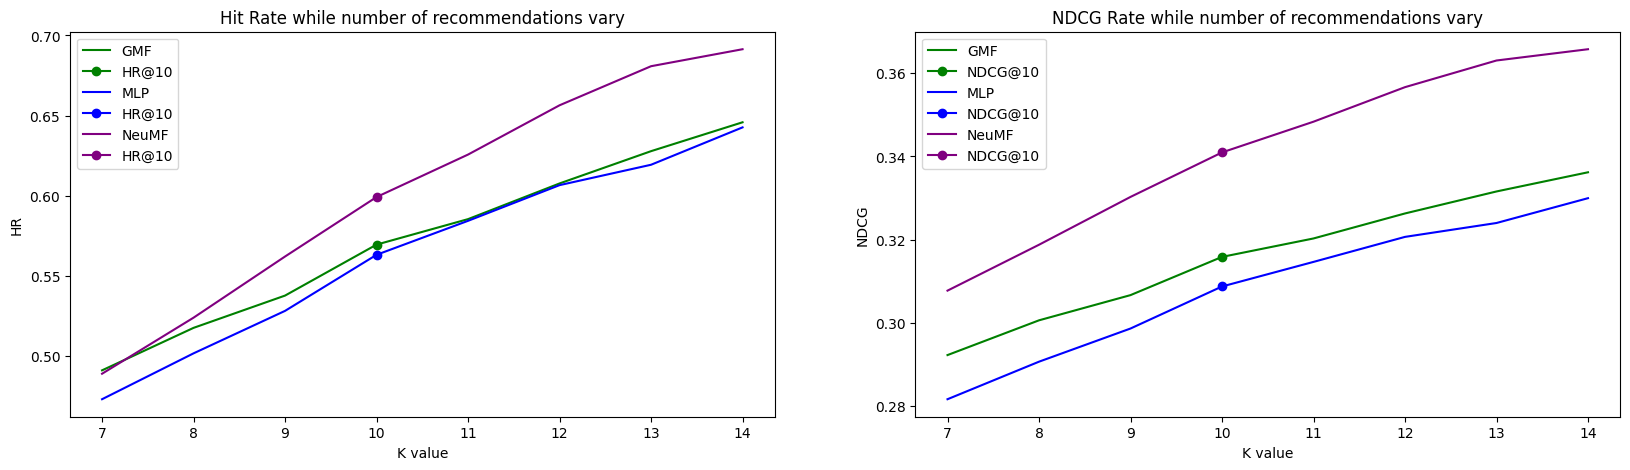

In [18]:
import matplotlib.pyplot as plt
fig, (hr_ax, ndcg_ax) = plt.subplots(1,2, figsize = (20, 5))
colors = ["green", "blue", "purple"]
for num, i in enumerate(HR.columns):
  hr_ax.plot(HR[i], label = i, color = colors[num])
  ndcg_ax.plot(NDCG[i], label = i, color = colors[num])
  hr_ax.plot([10],[HR[i][10]], marker = "o", color = colors[num], label = "HR@10")
  ndcg_ax.plot([10],[NDCG[i][10]], marker = "o", color = colors[num], label = "NDCG@10")


hr_ax.set_title("Hit Rate while number of recommendations vary")
ndcg_ax.set_title("NDCG Rate while number of recommendations vary")
hr_ax.set_ylabel("HR")
hr_ax.set_xlabel("K value")
ndcg_ax.set_ylabel("NDCG")
ndcg_ax.set_xlabel("K value")
hr_ax.legend()
ndcg_ax.legend()
plt.show()

# Task 3 - Metrics Evaluation while num factors vary

Here, we compare the three models with different num_factors: the idea is to find the optimal number of latent variables to describe the user-item interactions.

In [19]:
num_factors = [8, 16, 32, 64]
#do not change the order of HR and NDCG matrices
model_names = ["GMF Model", "MLP Model", "NeuMF model"]
mlp_models, gmf_models, nmf_models = {}, {}, {}

#I create a dict containing as the key the num_factor and as a value the relative model 
for num in num_factors:
    mlp_models[num] = torch.load(MODEL_PATH + "MLP{}.pt".format(num), map_location = device)
    gmf_models[num] = torch.load(MODEL_PATH + "GMF{}.pt".format(num), map_location = device)
    nmf_models[num] = torch.load(MODEL_PATH + "NeuMF{}.pt".format(num), map_location = device)

In [20]:
HR, NDCG = list([]), list([])

#for each num factor and for each model I compute the provided metrics on the test set
for num in tqdm(num_factors):
    hr_gmf, ndcg_gmf = metrics(gmf_models[num], test_loader, 10, device)
    hr_mlp, ndcg_mlp = metrics(mlp_models[num], test_loader, 10, device)
    hr_nmf, ndcg_nmf = metrics(nmf_models[num], test_loader, 10, device)
    HR.append([hr_gmf, hr_mlp, hr_nmf])
    NDCG.append([ndcg_gmf, ndcg_mlp, ndcg_nmf])

100%|██████████| 4/4 [00:24<00:00,  6.07s/it]


In [21]:
#Here I transpose the matrices because I need to have on the same row the results of the metrics for the same model (in order to construct the bar plot)
HR = np.array(HR).T
NDCG = np.array(NDCG).T

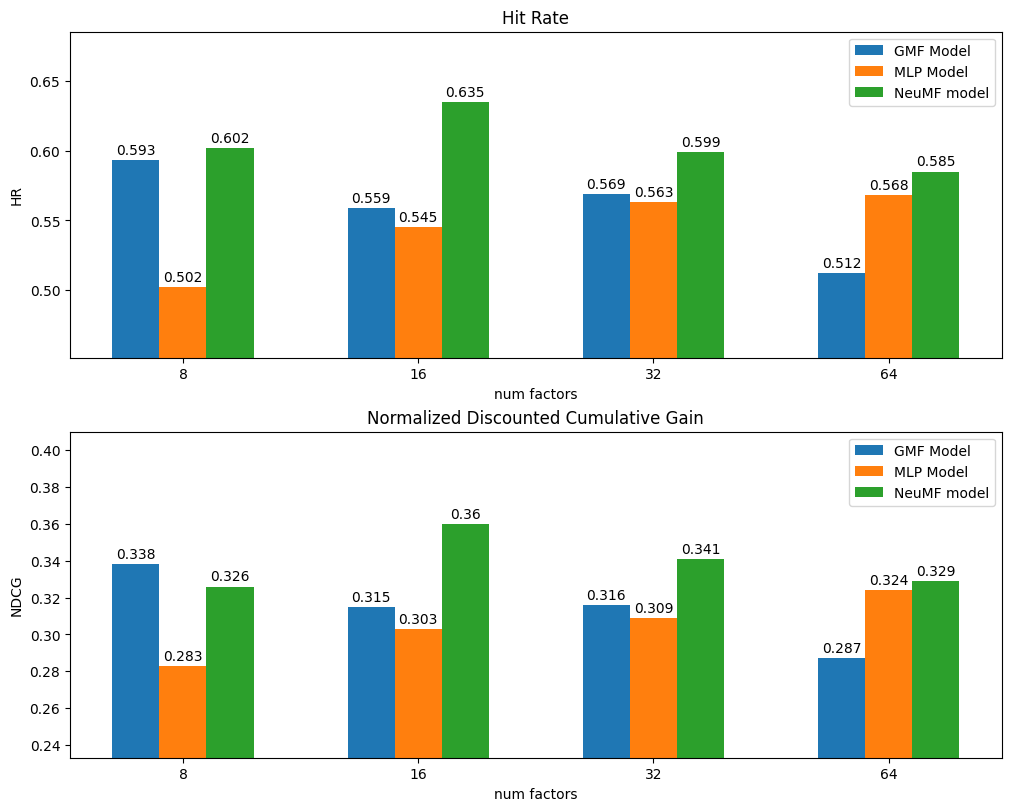

In [22]:
from matplotlib.container import BarContainer 
fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained', figsize = (10,8))
x = np.arange(HR.shape[1])
offset = -0.2
for i in range(len(HR)):
    rects1 = ax1.bar(x + offset, np.round(HR[i], 3), width=0.2, label = model_names[i])
    rects2 = ax2.bar(x + offset, np.round(NDCG[i], 3), width=0.2, label = model_names[i])
    ax1.bar_label(rects1, padding = 2)
    ax2.bar_label(rects2, padding = 2)
    offset += 0.2

ax1.set_ylim(min(HR.reshape(-1,1)) - 0.05, max(HR.reshape(-1,1)) + 0.05)
ax2.set_ylim(min(NDCG.reshape(-1,1)) - 0.05, max(NDCG.reshape(-1,1)) + 0.05)

ax1.set_xticks(x)
ax1.set_ylabel("HR")
ax1.set_xticklabels(num_factors)
ax1.set_xlabel("num factors")


ax2.set_xticks(x)
ax2.set_ylabel("NDCG")
ax2.set_xlabel("num factors")
ax2.set_xticklabels(num_factors)

ax1.set_title("Hit Rate")
ax2.set_title("Normalized Discounted Cumulative Gain")

ax1.legend()
ax2.legend()



## HyperParameter Tuning With RayTune

Finally, we decided to use the RayTune library in order to perform the HyperParameter tuning of the models, in order to find the configuration that returns the best results.

### We first need to define a config dict that defines the search space of the hyperparameters

In [23]:
# Prob Distr for dropout parameters for hyerparameters tuning
emb = np.random.choice([0, 0.2, 0.5], size = (20, ), p = [0.6, 0.3, 0.1])
mlp = np.random.choice([0, 0.2, 0.5], size = (20, ), p = [0.2, 0.3, 0.5])
mix = np.random.choice([0, 0.2, 0.5], size = (20, ), p = [0.5, 0.4, 0.1])

dropout_table = np.array([mix, emb, emb, mlp]).T
dropout_table


array([[0. , 0. , 0. , 0.5],
       [0. , 0.5, 0.5, 0. ],
       [0. , 0.2, 0.2, 0.2],
       [0.5, 0. , 0. , 0.2],
       [0. , 0. , 0. , 0.2],
       [0.2, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.2, 0.5],
       [0.2, 0.2, 0.2, 0.5],
       [0. , 0.2, 0.2, 0. ],
       [0.5, 0. , 0. , 0.5],
       [0.2, 0.5, 0.5, 0. ],
       [0.5, 0.2, 0.2, 0. ],
       [0.2, 0. , 0. , 0.5],
       [0.2, 0. , 0. , 0.5],
       [0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0.2],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0.2]])

In [24]:
config = {
    "lr": tune.choice([0.01, 0.001]),
    "batch_size": tune.choice([128, 256, 512]),
    "num_factors_gmf": 8,#tune.choice([8, 16, 32, 64]),
    "num_factors_mlp": 64,#tune.choice([8, 16, 32, 64]),
    "epochs": 20,
    "out": True,
    "dropout": tune.choice(dropout_table)
}

In [25]:
config = {
    "lr": 0.01,
    "batch_size": tune.choice([128, 256]),
    "num_factors_gmf": tune.choice([8, 16, 32]),#tune.choice([8, 16, 32, 64]),
    "num_factors_mlp": 64,#tune.choice([8, 16, 32, 64]),
    "epochs": 20,
    "out": True,
    "dropout": [0, 0, 0, 0]
}

### Initialize the scheduler and running the HT procedure
There is a paper related to the ASAH Scheduler at :https://arxiv.org/abs/1810.05934

In [26]:
scheduler = ASHAScheduler(
        metric="HitRate",
        mode="max",
        max_t=20,
        grace_period=8,
        reduction_factor=2)

reporter = CLIReporter(
        metric_columns=["HitRate"]
)

### Train Function
We have to define a train function that takes as argument the config file.
This function will:
- Initialize NeuMF model with the specified config parameters (num factors, layers, dropout vector for the different layers)
- Initialize Train and validation dataloaders
- Train the model on the Train dataloader
- Evaluate the validation loss and report it to RayTune
- Save the best model


In [27]:
# trains and save the model and returns the lists of train_loss and validation_loss
def train_NeuMF(config, model = None):
    # model = NeuMF_parametric_dropout(config['num_factors'], num_users, num_items, config['layers'], config['dropout'])
    new = False
    if model == None:
        model = NeuMF(
            config["num_factors_gmf"], config['num_factors_mlp'], num_users, num_items, config["dropout"]
        )
        new = True

    model = model.to(device)

    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    best_hr = 0

    for epoch in range(config["epochs"]):
        model.train()  # Enable dropout (if present).
        start_time = time.time()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()

        model.eval()
        HR, NDCG = metrics(model, test_loader, args["top_k"], device)

        elapsed_time = time.time() - start_time
        if not new:
            print(
                "Epoch {:03d}".format(epoch)
                + " time to train: "
                + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
            )
            print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

        if HR > best_hr:
            best_hr = HR
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                if new:
                    torch.save(
                        model, "{}{}{}_tuned.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors)
                    )
                else:
                    torch.save(
                        model, "{}{}{}_local_search.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors)
                    )


        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(HitRate=HR)


In [28]:
result = tune.run(
    train_NeuMF,
    local_dir="./checkpoints/",
    resources_per_trial={"cpu": 8},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter,
    checkpoint_at_end=False,
)

2023-03-24 13:35:54,711	INFO worker.py:1553 -- Started a local Ray instance.


== Status ==
Current time: 2023-03-24 13:35:57 (running for 00:00:01.21)
Memory usage on this node: 4.3/15.2 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.63 GiB heap, 0.0/3.81 GiB objects
Result logdir: /home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/checkpoints/train_NeuMF_2023-03-24_13-35-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+---------------------+--------------+-------------------+
| Trial name              | status   | loc                 |   batch_size |   num_factors_gmf |
|-------------------------+----------+---------------------+--------------+-------------------|
| train_NeuMF_6c8af_00000 | RUNNING  | 10.253.219.100:8721 |          256 |                 8 |
| train_NeuMF_6c8af_00001 | PENDING  |                     |          128 |                16 |
| train_NeuMF_6c8af_00002 | PENDING  |              

2023-03-24 13:36:05,433	WARNING tune.py:146 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-03-24 13:36:05,443	ERROR tune.py:794 -- Trials did not complete: [train_NeuMF_6c8af_00000, train_NeuMF_6c8af_00001, train_NeuMF_6c8af_00002, train_NeuMF_6c8af_00003, train_NeuMF_6c8af_00004, train_NeuMF_6c8af_00005, train_NeuMF_6c8af_00006, train_NeuMF_6c8af_00007, train_NeuMF_6c8af_00008, train_NeuMF_6c8af_00009]
2023-03-24 13:36:05,444	INFO tune.py:798 -- Total run time: 9.04 seconds (8.81 seconds for the tuning loop).
2023-03-24 13:36:05,444	WARNING tune.py:804 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


== Status ==
Current time: 2023-03-24 13:36:05 (running for 00:00:08.81)
Memory usage on this node: 4.7/15.2 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.63 GiB heap, 0.0/3.81 GiB objects
Result logdir: /home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/checkpoints/train_NeuMF_2023-03-24_13-35-56
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+---------------------+--------------+-------------------+
| Trial name              | status   | loc                 |   batch_size |   num_factors_gmf |
|-------------------------+----------+---------------------+--------------+-------------------|
| train_NeuMF_6c8af_00000 | RUNNING  | 10.253.219.100:8721 |          256 |                 8 |
| train_NeuMF_6c8af_00001 | PENDING  |                     |          128 |                16 |
| train_NeuMF_6c8af_00002 | PENDING  |              

In [ ]:

best_trial = result.get_best_trial("loss", "min", "last")
best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))

best_trained_model = NeuMF(best_trial.config["num_factors"], num_users, num_items, best_trial.config["layers"], best_trial.config['dropout']) 

best_trained_model.load_state_dict(model_state)
torch.save(best_trained_model, '{}{}{}_best_so_far.pt'.format(MODEL_PATH, best_trained_model.__class__.__name__, best_trained_model.factor_num))

best_trial.config

### Reporting the best configuration in our tests

In [ ]:
best_config = {
    "lr": 0.01,
    "batch_size": 128,#128
    "num_factors_gmf": 8,
    "num_factors_mlp": 64,
    "epochs": 25,
    "out": True,
    "dropout": [0, 0, 0, 0],
}

In [ ]:
best = torch.load(MODEL_PATH+"NeuMF64_tuned.pt")

HR, NDCG = metrics(best, test_loader, 10, device)
HR, NDCG

(0.6352067868504772, 0.37114583318415056)

In [ ]:
train_NeuMF(best_config)

Session not detected. You should not be calling `checkpoint_dir` outside `tuner.fit()` or while using the class API. 
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filter

In [ ]:
last_trained = torch.load(MODEL_PATH+"NeuMF64_tuned.pt")
HR, NDCG = metrics(last_trained, test_loader, 10, device)
HR, NDCG

(0.6224814422057264, 0.35206504761395885)

## Local search

In [ ]:
local_config = best_config.copy()
local_config['lr'] = 0.0001

nmf_model = torch.load(MODEL_PATH+"NeuMF64_test.pt")
train_NeuMF(local_config, nmf_model)

Session not detected. You should not be calling `checkpoint_dir` outside `tuner.fit()` or while using the class API. 
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filtering/Assignment1/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/home/agoniko/Desktop/Uni/DEEP_LEARNING/Neural_collaborative_filter

Epoch 000 time to train: 00: 00: 11
HR: 0.656	NDCG: 0.375
Epoch 001 time to train: 00: 00: 12
HR: 0.656	NDCG: 0.375
Epoch 002 time to train: 00: 00: 12
HR: 0.655	NDCG: 0.374


KeyboardInterrupt: 